<a href="https://colab.research.google.com/github/sayanbanerjee32/TASI_ERAv2_S9/blob/main/S9_stride2_dilated_SayanBanerjee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all required packages including local files

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np

#import from local modules
from utils import Cifar10Dataset
from utils import train, test, checkpoint, resume
from utils import get_device, plot_accuracy_losses, plot_top_loss
# from models import Net

# Check if GPU available

In [42]:
# CUDA? - call get_device function defined in utils.py
is_cuda, device = get_device()

CUDA Available? True


# Visualising Train data

# Dataset and Creating Train/Test Split

In [43]:
train_data_raw = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [44]:
# train data shape
print(train_data_raw.data.shape)
# train data mean
print(train_data_raw.data.mean(axis=(0,1,2))/255)
# train data standard deviation
print(train_data_raw.data.std(axis=(0,1,2))/255)

(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


# Dataloader Arguments & Test/Train Dataloaders

In [45]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if is_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader_raw = torch.utils.data.DataLoader(train_data_raw, **dataloader_args)

class_labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Data Visualization

torch.Size([128, 3, 32, 32])
torch.Size([128])


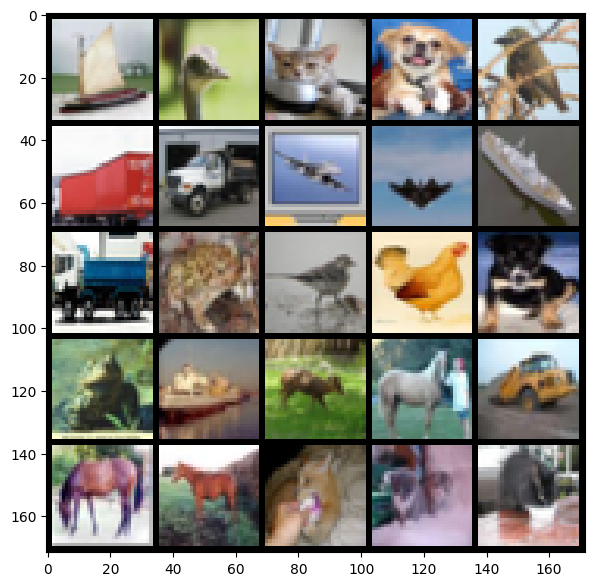

In [46]:
dataiter = iter(train_loader_raw)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Create a grid of images
grid = torchvision.utils.make_grid(images[:25], nrow=5)

# Display the grid
plt.figure(figsize=(7,7))
plt.imshow(grid.permute(1,2,0))
plt.show()

In [47]:
# how labels look like
print(' '.join(f'{class_labels[labels[j]]:5s}' for j in range(len(labels[:25]))))

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat  


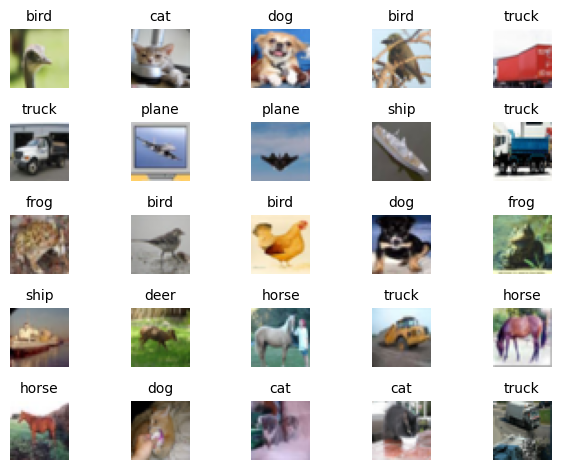

In [48]:
figure = plt.figure()
rows, cols = 5, 5
for index in range(1, cols * rows  + 1):
    plt.subplot(rows, cols, index)
    plt.title(class_labels[labels[index]],fontsize = 10)
    plt.axis('off')
    plt.imshow(images[index].permute(1, 2, 0))
figure.tight_layout()
plt.show()

# Train and Test transformations

In [49]:
# Train Phase transformations
train_transforms = A.Compose([
                                # A.Compose([
                                #     A.PadIfNeeded (min_height=36, min_width=36, p = 1.0),
                                #     A.RandomCrop(p=1, height=32, width=32),
                                # ], p = 0.5),
                                A.HorizontalFlip(p=0.5),
                                A.ShiftScaleRotate(p=0.5),
                                # A.ColorJitter(p = 0.5),
                                A.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.262)),
                                # A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16,
                                #                 fill_value=[0.4914,0.4822,0.4465], mask_fill_value = None, p=0.5),
                                A.Compose([A.PadIfNeeded (min_height=64, min_width=64, p = 1.0),
                                            A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16,
                                                fill_value=[0.4914,0.4822,0.4465], mask_fill_value = None, p=1),
                                           A.CenterCrop(height=32, width=32, p=1),
                                ], p = 1),
                                ToTensorV2(),
                                ])

# Test Phase transformations
test_transforms = A.Compose([
                            A.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.262)),
                            ToTensorV2(),
                            ])

# Dataset and Creating Train/Test Split

In [50]:
# train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
# test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)
train_data = Cifar10Dataset(transform=train_transforms)
test_data = Cifar10Dataset(train=False, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [51]:
train_data

Dataset Cifar10Dataset
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose([
             HorizontalFlip(always_apply=False, p=0.5),
             ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-45, 45), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box'),
             Normalize(always_apply=False, p=1.0, mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.262), max_pixel_value=255.0),
             Compose([
               PadIfNeeded(always_apply=False, p=1.0, min_height=64, min_width=64, pad_height_divisor=None, pad_width_divisor=None, border_mode=4, value=None, mask_value=None),
               CoarseDropout(always_apply=False, p=1, max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=[0.4914, 0.4822, 0.4465], m

# Dataloader Arguments & Test/Train Dataloaders

In [52]:
# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

### Augmented data visualization

torch.Size([128, 3, 32, 32])
torch.Size([128])


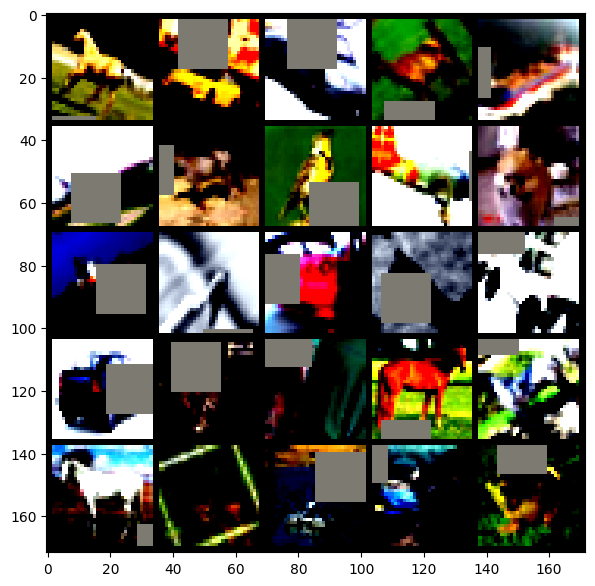

In [53]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Create a grid of images
grid = torchvision.utils.make_grid(images[:25], nrow=5)

# Display the grid
plt.figure(figsize=(7,7))
plt.imshow(grid.permute(1,2,0))
plt.show()

# Training

In [54]:
class Net(nn.Module):
    def __init__(self, dropout_value = 0.1):
        super(Net, self).__init__()
        # # Input Block / CONVOLUTION BLOCK 1
        self.C1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) #input size: 32 x 32 x 3, output size: 32 x 32 x 32, receptive field: 1 + (3-1) * 1 = 3


        self.C2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) #input size: 32 x 32 x 32, output size: 32 x 32 x 64, receptive field: 3 + (3-1) * 1 = 5

        ## Strided convolution
        self.SC1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32,
                      kernel_size=(3, 3), padding=1, stride = 2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) #input size: 32 x 32 x n*2, output size: 24 x 24 x n*4, receptive field: 3 + (3-1) * 1 = 5
        #Lout =  (Lin + 2 * padding - dilation * (kernel - 1) - 1) / stride + 1
        # ((32 + 2 * 1 - 1 * (3 - 1) -1) / 2) + 1 = 16

        # # ## dilated convolution
        # self.SC1 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=32,
        #               kernel_size=(3, 3), padding=0, dilation = 6, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(32),
        #     nn.Dropout(dropout_value)
        # ) #input size: 32 x 32 x n*2, output size: 24 x 24 x n*4, receptive field: 3 + (3-1) * 1 = 5
        # # ((32 + 2 * 1 - 8 * (3 - 1) -1) / 1) + 1 = 25

        # # TRANSITION BLOCK 1
        # self.t1 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=16,
        #               kernel_size=(1, 1), padding=0, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(16),
        #     nn.Dropout(dropout_value)
        # ) #input size: 17 x 17 x n*4, output size: 17 x 17 x n, receptive field: 6 + (1-1)*2 = 6


        # CONVOLUTION BLOCK 2
        self.C3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n, output size: 16 x 16 x n*2, receptive field: 6 + (3-1) * 2 = 10

        self.C4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*2, output size: 16 x 16 x n*4, receptive field: 10 + (3-1) * 2 = 14

        self.C4_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*2, output size: 16 x 16 x n*4, receptive field: 10 + (3-1) * 2 = 14


        self.SC2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=(3, 3), padding=1, stride = 2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n*4, receptive field: 14 + (3-1) * 2 = 18

        # self.SC2 = nn.Sequential(
        #     nn.Conv2d(in_channels=64, out_channels=64,
        #               kernel_size=(3, 3), padding=0, dilation = 4, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(64),
        #     nn.Dropout(dropout_value)
        # ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n*4, receptive field: 14 + (3-1) * 2 = 18
        # ((18 + 2 * 1 - 4 * (3 - 1) -1) / 1) + 1 = 12
        # TRANSITION BLOCK 2
        self.t2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32,
                      kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n, receptive field: 18 + (1-1)*2 = 18

        # CONVOLUTION BLOCK 3
        # self.C5 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=64,
        #               kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(64),
        #     nn.Dropout(dropout_value)
        # ) #input size: 16 x 16 x n, output size: 16 x 16 x n*2, receptive field: 6 + (3-1) * 2 = 10

        # self.C6 = nn.Sequential(
        #     nn.Conv2d(in_channels=64, out_channels=128,
        #               kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(128),
        #     nn.Dropout(dropout_value)
        # ) #input size: 16 x 16 x n*2, output size: 16 x 16 x n*4, receptive field: 10 + (3-1) * 2 = 14
        self.C5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups = 32,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n, output size: 16 x 16 x n*2, receptive field: 6 + (3-1) * 2 = 10

        self.C6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, groups = 64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*2, output size: 16 x 16 x n*4, receptive field: 10 + (3-1) * 2 = 14

        self.C7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, groups = 64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*2, output size: 16 x 16 x n*4, receptive field: 10 + (3-1) * 2 = 14

        # self.SC3 = nn.Sequential(
        #     nn.Conv2d(in_channels=64, out_channels=64,
        #               kernel_size=(3, 3), padding=1, stride = 2, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(64),
        #     nn.Dropout(dropout_value)
        # ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n*4, receptive field: 14 + (3-1) * 2 = 18
        self.SC3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=(3, 3), padding=0, dilation = 2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n*4, receptive field: 14 + (3-1) * 2 = 18
        # ((12 + 2 * 1 - 4 * (3 - 1) -1) / 1) + 1 = 11
        # TRANSITION BLOCK 3
        self.t3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32,
                      kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n, receptive field: 18 + (1-1)*2 = 18

        # CONVOLUTION BLOCK 4

        # self.C7 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=64,
        #               kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(64),
        #     nn.Dropout(dropout_value)
        # ) #input size: 8 x 8 x n, output size: 8 x 8 x n*2, receptive field: 20 + (3-1) * 4 = 28

        # self.C8 = nn.Sequential(
        #     nn.Conv2d(in_channels=64, out_channels=128,
        #               kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(128),
        #     nn.Dropout(dropout_value)
        # ) #input size: 8 x 8 x n*2, output size: 8 x 8 x n*4, receptive field: 28 + (3-1) * 4 = 36

        self.C8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups = 32,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 8 x 8 x n, output size: 8 x 8 x n*2, receptive field: 20 + (3-1) * 4 = 28

        self.C9 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) #input size: 8 x 8 x n*2, output size: 8 x 8 x n*4, receptive field: 28 + (3-1) * 4 = 36

        self.C10 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, groups = 128,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) #input size: 8 x 8 x n*4, output size: 8 x 8 x n*4, receptive field: 36 + (3-1) * 4 = 44

        # OUTPUT BLOCK
        self.GAP = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1))
        ) #input size: 8 x 8 x n*4, output size: 1 x 1 x n*4, receptive field: 44

        self.c11 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10,
                      kernel_size=(1, 1), padding=0, bias=False),
        ) #input size: 1 x 1 x n*4, output size: 1 x 1 x 10, receptive field: 44 + (1-1) * 4 =44



    def forward(self, x):
        x = self.C1(x)
        x = x + self.C2(x)

        x = self.SC1(x)
        # x = self.t1(x)

        x = self.C3(x)
        x = self.C4(x)
        x = x + self.C4_1(x)

        x = self.SC2(x)
        x = self.t2(x)

        x = self.C5(x)
        x = self.C6(x)
        x = x + self.C7(x)

        x = self.SC3(x)
        x = self.t3(x)

        x = self.C8(x)
        x = self.C9(x)
        x = self.C10(x)

        x = self.GAP(x)
        x = self.c11(x)

        x = x.squeeze()

        return F.log_softmax(x, dim=-1)

In [55]:
# visualise model parameters
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           9,216
             ReLU-10           [-1, 32, 16, 16]               0
      BatchNorm2d-11           [-1, 32, 16, 16]              64
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
             ReLU-14           [-1, 64,

strided - 641,248 - 51% - 74%  
Dilated - 641,248 - 47% - 68%

197,152
with random resized crop
61% - 75% (56 e) - 53% - 69% (20e)

wo
dilated - 65% - 74% (20 e)  
        76% - 81% (72 e)

In [56]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [57]:
current_learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=current_learning_rate,
                      momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer  = optimizer,
                                                 mode = 'min',
                                                 factor = 0.1,
                                                 min_lr = 0.0001,
                                                 threshold_mode  = 'rel',
                                                 threshold = 0.0001,
                                                 patience  = 3,
                                                 verbose = True)
criterion = F.nll_loss
num_epochs = 100
early_stopping_patience = 10
best_test_loss = np.inf
best_epoch = -1

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    # call train function from utils.py
    trn_acc, trn_loss = train(model, device, train_loader, optimizer, criterion)
    # accumulate train accuracies and test losses for visualisation
    train_acc.append(trn_acc)
    train_losses.append(trn_loss)

    # call test function from utils.py
    tst_acc, tst_loss = test(model, device, test_loader, criterion)
    # accumulate test accuracies and test losses for visualisation
    test_acc.append(tst_acc)
    test_losses.append(tst_loss)

    scheduler.step(tst_loss)
    if current_learning_rate != scheduler.get_last_lr()[0]:
        current_learning_rate = scheduler.get_last_lr()[0]
        print(f'Learning rate updated to: {current_learning_rate}')
        best_epoch = epoch
        # break

    # early stopping
    if tst_loss < best_test_loss:
        best_test_loss = tst_loss
        best_epoch = epoch
        checkpoint(model, "best_model.pth")
    elif epoch - best_epoch > early_stopping_patience:
        print("Early stopped training at epoch %d" % epoch)
        break  # terminate the training loop

resume(model, "best_model.pth")

Epoch 1


Train: Loss=1.6906 Batch_id=390 Accuracy=34.45: 100%|██████████| 391/391 [00:18<00:00, 21.48it/s]


Test set: Average loss: 1.4839, Accuracy: 4461/10000 (44.61%)

Epoch 2


Train: Loss=1.6362 Batch_id=390 Accuracy=43.33: 100%|██████████| 391/391 [00:17<00:00, 21.97it/s]


Test set: Average loss: 1.3244, Accuracy: 5152/10000 (51.52%)

Epoch 3


Train: Loss=1.2901 Batch_id=390 Accuracy=48.41: 100%|██████████| 391/391 [00:19<00:00, 20.33it/s]


Test set: Average loss: 1.2359, Accuracy: 5544/10000 (55.44%)

Epoch 4


Train: Loss=1.2601 Batch_id=390 Accuracy=52.37: 100%|██████████| 391/391 [00:17<00:00, 21.97it/s]


Test set: Average loss: 1.1148, Accuracy: 6046/10000 (60.46%)

Epoch 5


Train: Loss=1.3736 Batch_id=390 Accuracy=55.10: 100%|██████████| 391/391 [00:18<00:00, 21.44it/s]


Test set: Average loss: 1.0381, Accuracy: 6347/10000 (63.47%)

Epoch 6


Train: Loss=1.2980 Batch_id=390 Accuracy=58.02: 100%|██████████| 391/391 [00:18<00:00, 21.02it/s]


Test set: Average loss: 0.9654, Accuracy: 6583/10000 (65.83%)

Epoch 7


Train: Loss=1.0488 Batch_id=390 Accuracy=59.48: 100%|██████████| 391/391 [00:18<00:00, 21.21it/s]


Test set: Average loss: 0.9292, Accuracy: 6704/10000 (67.04%)

Epoch 8


Train: Loss=1.1981 Batch_id=390 Accuracy=61.47: 100%|██████████| 391/391 [00:18<00:00, 21.67it/s]


Test set: Average loss: 0.8452, Accuracy: 7022/10000 (70.22%)

Epoch 9


Train: Loss=1.1384 Batch_id=390 Accuracy=62.99: 100%|██████████| 391/391 [00:18<00:00, 21.04it/s]


Test set: Average loss: 0.8074, Accuracy: 7210/10000 (72.10%)

Epoch 10


Train: Loss=1.0578 Batch_id=390 Accuracy=64.31: 100%|██████████| 391/391 [00:17<00:00, 22.01it/s]


Test set: Average loss: 0.7684, Accuracy: 7347/10000 (73.47%)

Epoch 11


Train: Loss=0.9182 Batch_id=390 Accuracy=65.25: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s]


Test set: Average loss: 0.7620, Accuracy: 7320/10000 (73.20%)

Epoch 12


Train: Loss=0.8062 Batch_id=390 Accuracy=65.97: 100%|██████████| 391/391 [00:17<00:00, 22.03it/s]


Test set: Average loss: 0.7020, Accuracy: 7567/10000 (75.67%)

Epoch 13


Train: Loss=1.0930 Batch_id=390 Accuracy=67.04: 100%|██████████| 391/391 [00:18<00:00, 20.88it/s]


Test set: Average loss: 0.6978, Accuracy: 7595/10000 (75.95%)

Epoch 14


Train: Loss=0.9386 Batch_id=390 Accuracy=67.43: 100%|██████████| 391/391 [00:17<00:00, 22.04it/s]


Test set: Average loss: 0.6924, Accuracy: 7660/10000 (76.60%)

Epoch 15


Train: Loss=0.7936 Batch_id=390 Accuracy=68.16: 100%|██████████| 391/391 [00:18<00:00, 21.09it/s]


Test set: Average loss: 0.6881, Accuracy: 7668/10000 (76.68%)

Epoch 16


Train: Loss=1.0562 Batch_id=390 Accuracy=69.24: 100%|██████████| 391/391 [00:17<00:00, 21.88it/s]


Test set: Average loss: 0.6776, Accuracy: 7630/10000 (76.30%)

Epoch 17


Train: Loss=0.8327 Batch_id=390 Accuracy=69.63: 100%|██████████| 391/391 [00:18<00:00, 20.72it/s]


Test set: Average loss: 0.6363, Accuracy: 7813/10000 (78.13%)

Epoch 18


Train: Loss=0.8876 Batch_id=390 Accuracy=70.33: 100%|██████████| 391/391 [00:18<00:00, 20.98it/s]


Test set: Average loss: 0.6185, Accuracy: 7891/10000 (78.91%)

Epoch 19


Train: Loss=0.9325 Batch_id=390 Accuracy=70.73: 100%|██████████| 391/391 [00:18<00:00, 21.14it/s]


Test set: Average loss: 0.6195, Accuracy: 7927/10000 (79.27%)

Epoch 20


Train: Loss=0.7970 Batch_id=390 Accuracy=71.37: 100%|██████████| 391/391 [00:17<00:00, 22.35it/s]


Test set: Average loss: 0.6056, Accuracy: 7938/10000 (79.38%)

Epoch 21


Train: Loss=0.6546 Batch_id=390 Accuracy=71.42: 100%|██████████| 391/391 [00:18<00:00, 20.82it/s]


Test set: Average loss: 0.5905, Accuracy: 7951/10000 (79.51%)

Epoch 22


Train: Loss=0.9590 Batch_id=390 Accuracy=71.87: 100%|██████████| 391/391 [00:17<00:00, 22.08it/s]


Test set: Average loss: 0.6061, Accuracy: 7938/10000 (79.38%)

Epoch 23


Train: Loss=0.6708 Batch_id=390 Accuracy=71.95: 100%|██████████| 391/391 [00:18<00:00, 21.07it/s]


Test set: Average loss: 0.5702, Accuracy: 8070/10000 (80.70%)

Epoch 24


Train: Loss=0.8417 Batch_id=390 Accuracy=72.88: 100%|██████████| 391/391 [00:17<00:00, 22.04it/s]


Test set: Average loss: 0.5609, Accuracy: 8145/10000 (81.45%)

Epoch 25


Train: Loss=0.6296 Batch_id=390 Accuracy=73.03: 100%|██████████| 391/391 [00:18<00:00, 20.98it/s]


Test set: Average loss: 0.5572, Accuracy: 8079/10000 (80.79%)

Epoch 26


Train: Loss=0.7786 Batch_id=390 Accuracy=73.03: 100%|██████████| 391/391 [00:17<00:00, 22.36it/s]


Test set: Average loss: 0.5489, Accuracy: 8138/10000 (81.38%)

Epoch 27


Train: Loss=0.9823 Batch_id=390 Accuracy=73.49: 100%|██████████| 391/391 [00:19<00:00, 20.45it/s]


Test set: Average loss: 0.5386, Accuracy: 8155/10000 (81.55%)

Epoch 28


Train: Loss=0.8768 Batch_id=390 Accuracy=74.29: 100%|██████████| 391/391 [00:17<00:00, 21.90it/s]


Test set: Average loss: 0.5255, Accuracy: 8180/10000 (81.80%)

Epoch 29


Train: Loss=0.8748 Batch_id=390 Accuracy=74.03: 100%|██████████| 391/391 [00:18<00:00, 21.58it/s]


Test set: Average loss: 0.5326, Accuracy: 8190/10000 (81.90%)

Epoch 30


Train: Loss=0.7853 Batch_id=390 Accuracy=74.64: 100%|██████████| 391/391 [00:17<00:00, 22.11it/s]


Test set: Average loss: 0.5316, Accuracy: 8222/10000 (82.22%)

Epoch 31


Train: Loss=0.8614 Batch_id=390 Accuracy=74.72: 100%|██████████| 391/391 [00:18<00:00, 21.48it/s]


Test set: Average loss: 0.5237, Accuracy: 8237/10000 (82.37%)

Epoch 32


Train: Loss=0.6028 Batch_id=390 Accuracy=75.15: 100%|██████████| 391/391 [00:17<00:00, 22.16it/s]


Test set: Average loss: 0.5083, Accuracy: 8292/10000 (82.92%)

Epoch 33


Train: Loss=0.4744 Batch_id=390 Accuracy=75.20: 100%|██████████| 391/391 [00:18<00:00, 21.32it/s]


Test set: Average loss: 0.4973, Accuracy: 8341/10000 (83.41%)

Epoch 34


Train: Loss=0.6707 Batch_id=390 Accuracy=75.44: 100%|██████████| 391/391 [00:17<00:00, 22.18it/s]


Test set: Average loss: 0.4990, Accuracy: 8336/10000 (83.36%)

Epoch 35


Train: Loss=0.9314 Batch_id=390 Accuracy=75.41: 100%|██████████| 391/391 [00:18<00:00, 21.43it/s]


Test set: Average loss: 0.5067, Accuracy: 8261/10000 (82.61%)

Epoch 36


Train: Loss=0.6861 Batch_id=390 Accuracy=75.68: 100%|██████████| 391/391 [00:18<00:00, 20.82it/s]


Test set: Average loss: 0.4996, Accuracy: 8278/10000 (82.78%)

Epoch 37


Train: Loss=1.0189 Batch_id=390 Accuracy=75.96: 100%|██████████| 391/391 [00:18<00:00, 21.26it/s]


Test set: Average loss: 0.5063, Accuracy: 8310/10000 (83.10%)

Learning rate updated to: 0.010000000000000002
Epoch 38


Train: Loss=0.5775 Batch_id=390 Accuracy=77.79: 100%|██████████| 391/391 [00:17<00:00, 22.17it/s]


Test set: Average loss: 0.4462, Accuracy: 8490/10000 (84.90%)

Epoch 39


Train: Loss=0.6095 Batch_id=390 Accuracy=78.45: 100%|██████████| 391/391 [00:18<00:00, 21.24it/s]


Test set: Average loss: 0.4387, Accuracy: 8526/10000 (85.26%)

Epoch 40


Train: Loss=0.6194 Batch_id=390 Accuracy=78.42: 100%|██████████| 391/391 [00:17<00:00, 22.18it/s]


Test set: Average loss: 0.4316, Accuracy: 8560/10000 (85.60%)

Epoch 41


Train: Loss=0.5635 Batch_id=390 Accuracy=78.55: 100%|██████████| 391/391 [00:18<00:00, 21.68it/s]


Test set: Average loss: 0.4349, Accuracy: 8541/10000 (85.41%)

Epoch 42


Train: Loss=0.6988 Batch_id=390 Accuracy=78.77: 100%|██████████| 391/391 [00:17<00:00, 22.13it/s]


Test set: Average loss: 0.4272, Accuracy: 8563/10000 (85.63%)

Epoch 43


Train: Loss=0.6633 Batch_id=390 Accuracy=78.68: 100%|██████████| 391/391 [00:17<00:00, 21.94it/s]


Test set: Average loss: 0.4247, Accuracy: 8572/10000 (85.72%)

Epoch 44


Train: Loss=0.7307 Batch_id=390 Accuracy=78.92: 100%|██████████| 391/391 [00:17<00:00, 22.19it/s]


Test set: Average loss: 0.4253, Accuracy: 8585/10000 (85.85%)

Epoch 45


Train: Loss=0.6966 Batch_id=390 Accuracy=79.21: 100%|██████████| 391/391 [00:19<00:00, 20.49it/s]


Test set: Average loss: 0.4237, Accuracy: 8573/10000 (85.73%)

Epoch 46


Train: Loss=0.7026 Batch_id=390 Accuracy=79.12: 100%|██████████| 391/391 [00:17<00:00, 22.34it/s]


Test set: Average loss: 0.4212, Accuracy: 8606/10000 (86.06%)

Epoch 47


Train: Loss=0.7596 Batch_id=390 Accuracy=78.91: 100%|██████████| 391/391 [00:18<00:00, 21.57it/s]


Test set: Average loss: 0.4199, Accuracy: 8584/10000 (85.84%)

Epoch 48


Train: Loss=0.5234 Batch_id=390 Accuracy=79.01: 100%|██████████| 391/391 [00:17<00:00, 22.18it/s]


Test set: Average loss: 0.4188, Accuracy: 8586/10000 (85.86%)

Epoch 49


Train: Loss=0.6054 Batch_id=390 Accuracy=79.19: 100%|██████████| 391/391 [00:17<00:00, 21.89it/s]


Test set: Average loss: 0.4140, Accuracy: 8602/10000 (86.02%)

Epoch 50


Train: Loss=0.5857 Batch_id=390 Accuracy=79.12: 100%|██████████| 391/391 [00:17<00:00, 22.31it/s]


Test set: Average loss: 0.4180, Accuracy: 8597/10000 (85.97%)

Epoch 51


Train: Loss=0.6650 Batch_id=390 Accuracy=79.26: 100%|██████████| 391/391 [00:17<00:00, 22.27it/s]


Test set: Average loss: 0.4133, Accuracy: 8630/10000 (86.30%)

Epoch 52


Train: Loss=0.6980 Batch_id=390 Accuracy=79.34: 100%|██████████| 391/391 [00:17<00:00, 22.05it/s]


Test set: Average loss: 0.4139, Accuracy: 8623/10000 (86.23%)

Epoch 53


Train: Loss=0.5594 Batch_id=390 Accuracy=79.52: 100%|██████████| 391/391 [00:17<00:00, 21.92it/s]


Test set: Average loss: 0.4119, Accuracy: 8623/10000 (86.23%)

Epoch 54


Train: Loss=0.3853 Batch_id=390 Accuracy=79.46: 100%|██████████| 391/391 [00:17<00:00, 21.88it/s]


Test set: Average loss: 0.4111, Accuracy: 8611/10000 (86.11%)

Epoch 55


Train: Loss=0.4956 Batch_id=390 Accuracy=79.33: 100%|██████████| 391/391 [00:18<00:00, 21.32it/s]


Test set: Average loss: 0.4125, Accuracy: 8611/10000 (86.11%)

Epoch 56


Train: Loss=0.6380 Batch_id=390 Accuracy=79.50: 100%|██████████| 391/391 [00:17<00:00, 22.32it/s]


Test set: Average loss: 0.4079, Accuracy: 8632/10000 (86.32%)

Epoch 57


Train: Loss=0.5531 Batch_id=390 Accuracy=79.54: 100%|██████████| 391/391 [00:17<00:00, 21.73it/s]


Test set: Average loss: 0.4098, Accuracy: 8645/10000 (86.45%)

Epoch 58


Train: Loss=0.6196 Batch_id=390 Accuracy=79.51: 100%|██████████| 391/391 [00:17<00:00, 22.32it/s]


Test set: Average loss: 0.4106, Accuracy: 8603/10000 (86.03%)

Epoch 59


Train: Loss=0.5536 Batch_id=390 Accuracy=79.62: 100%|██████████| 391/391 [00:17<00:00, 21.83it/s]


Test set: Average loss: 0.4086, Accuracy: 8636/10000 (86.36%)

Epoch 60


Train: Loss=0.6875 Batch_id=390 Accuracy=79.65: 100%|██████████| 391/391 [00:17<00:00, 21.93it/s]


Test set: Average loss: 0.4097, Accuracy: 8628/10000 (86.28%)

Learning rate updated to: 0.0010000000000000002
Epoch 61


Train: Loss=0.5456 Batch_id=390 Accuracy=79.48: 100%|██████████| 391/391 [00:17<00:00, 21.93it/s]


Test set: Average loss: 0.4070, Accuracy: 8642/10000 (86.42%)

Epoch 62


Train: Loss=0.6472 Batch_id=390 Accuracy=79.65: 100%|██████████| 391/391 [00:17<00:00, 22.37it/s]


Test set: Average loss: 0.4076, Accuracy: 8648/10000 (86.48%)

Epoch 63


Train: Loss=0.5982 Batch_id=390 Accuracy=79.80: 100%|██████████| 391/391 [00:17<00:00, 22.10it/s]


Test set: Average loss: 0.4045, Accuracy: 8641/10000 (86.41%)

Epoch 64


Train: Loss=0.5810 Batch_id=390 Accuracy=79.93: 100%|██████████| 391/391 [00:18<00:00, 20.70it/s]


Test set: Average loss: 0.4048, Accuracy: 8650/10000 (86.50%)

Epoch 65


Train: Loss=0.6379 Batch_id=390 Accuracy=80.22: 100%|██████████| 391/391 [00:17<00:00, 22.02it/s]


Test set: Average loss: 0.4043, Accuracy: 8649/10000 (86.49%)

Epoch 66


Train: Loss=0.5482 Batch_id=390 Accuracy=79.84: 100%|██████████| 391/391 [00:17<00:00, 22.30it/s]


Test set: Average loss: 0.4037, Accuracy: 8649/10000 (86.49%)

Epoch 67


Train: Loss=0.3791 Batch_id=390 Accuracy=79.99: 100%|██████████| 391/391 [00:17<00:00, 21.95it/s]


Test set: Average loss: 0.4051, Accuracy: 8642/10000 (86.42%)

Epoch 68


Train: Loss=0.6333 Batch_id=390 Accuracy=80.04: 100%|██████████| 391/391 [00:17<00:00, 22.22it/s]


Test set: Average loss: 0.4049, Accuracy: 8646/10000 (86.46%)

Epoch 69


Train: Loss=0.4687 Batch_id=390 Accuracy=80.21: 100%|██████████| 391/391 [00:17<00:00, 21.91it/s]


Test set: Average loss: 0.4051, Accuracy: 8632/10000 (86.32%)

Epoch 70


Train: Loss=0.6309 Batch_id=390 Accuracy=80.05: 100%|██████████| 391/391 [00:17<00:00, 22.32it/s]


Test set: Average loss: 0.4045, Accuracy: 8653/10000 (86.53%)

Learning rate updated to: 0.00010000000000000003
Epoch 71


Train: Loss=0.6519 Batch_id=390 Accuracy=80.29: 100%|██████████| 391/391 [00:17<00:00, 21.88it/s]


Test set: Average loss: 0.4025, Accuracy: 8651/10000 (86.51%)

Epoch 72


Train: Loss=0.6847 Batch_id=390 Accuracy=79.96: 100%|██████████| 391/391 [00:17<00:00, 22.02it/s]


Test set: Average loss: 0.4052, Accuracy: 8639/10000 (86.39%)

Epoch 73


Train: Loss=0.5985 Batch_id=390 Accuracy=80.07: 100%|██████████| 391/391 [00:18<00:00, 20.60it/s]


Test set: Average loss: 0.4048, Accuracy: 8643/10000 (86.43%)

Epoch 74


Train: Loss=0.6029 Batch_id=390 Accuracy=80.02: 100%|██████████| 391/391 [00:17<00:00, 22.19it/s]


Test set: Average loss: 0.4029, Accuracy: 8659/10000 (86.59%)

Epoch 75


Train: Loss=0.5888 Batch_id=390 Accuracy=79.90: 100%|██████████| 391/391 [00:17<00:00, 21.83it/s]


Test set: Average loss: 0.4052, Accuracy: 8639/10000 (86.39%)

Epoch 76


Train: Loss=0.3790 Batch_id=390 Accuracy=80.22: 100%|██████████| 391/391 [00:17<00:00, 22.21it/s]


Test set: Average loss: 0.4051, Accuracy: 8646/10000 (86.46%)

Epoch 77


Train: Loss=0.6643 Batch_id=390 Accuracy=79.88: 100%|██████████| 391/391 [00:17<00:00, 22.07it/s]


Test set: Average loss: 0.4030, Accuracy: 8671/10000 (86.71%)

Epoch 78


Train: Loss=0.6790 Batch_id=390 Accuracy=79.87: 100%|██████████| 391/391 [00:17<00:00, 22.10it/s]


Test set: Average loss: 0.4044, Accuracy: 8647/10000 (86.47%)

Epoch 79


Train: Loss=0.5574 Batch_id=390 Accuracy=80.24: 100%|██████████| 391/391 [00:17<00:00, 22.00it/s]


Test set: Average loss: 0.4041, Accuracy: 8654/10000 (86.54%)

Epoch 80


Train: Loss=0.4509 Batch_id=390 Accuracy=79.91: 100%|██████████| 391/391 [00:17<00:00, 21.97it/s]


Test set: Average loss: 0.4029, Accuracy: 8657/10000 (86.57%)

Epoch 81


Train: Loss=0.7061 Batch_id=390 Accuracy=79.80: 100%|██████████| 391/391 [00:17<00:00, 22.16it/s]


Test set: Average loss: 0.4033, Accuracy: 8651/10000 (86.51%)

Epoch 82


Train: Loss=0.5439 Batch_id=390 Accuracy=79.96: 100%|██████████| 391/391 [00:17<00:00, 22.03it/s]


Test set: Average loss: 0.4030, Accuracy: 8668/10000 (86.68%)

Early stopped training at epoch 82


In [58]:
# final learning rate
scheduler.get_last_lr()

[0.00010000000000000003]

## Visualise training and test losses and accuracies

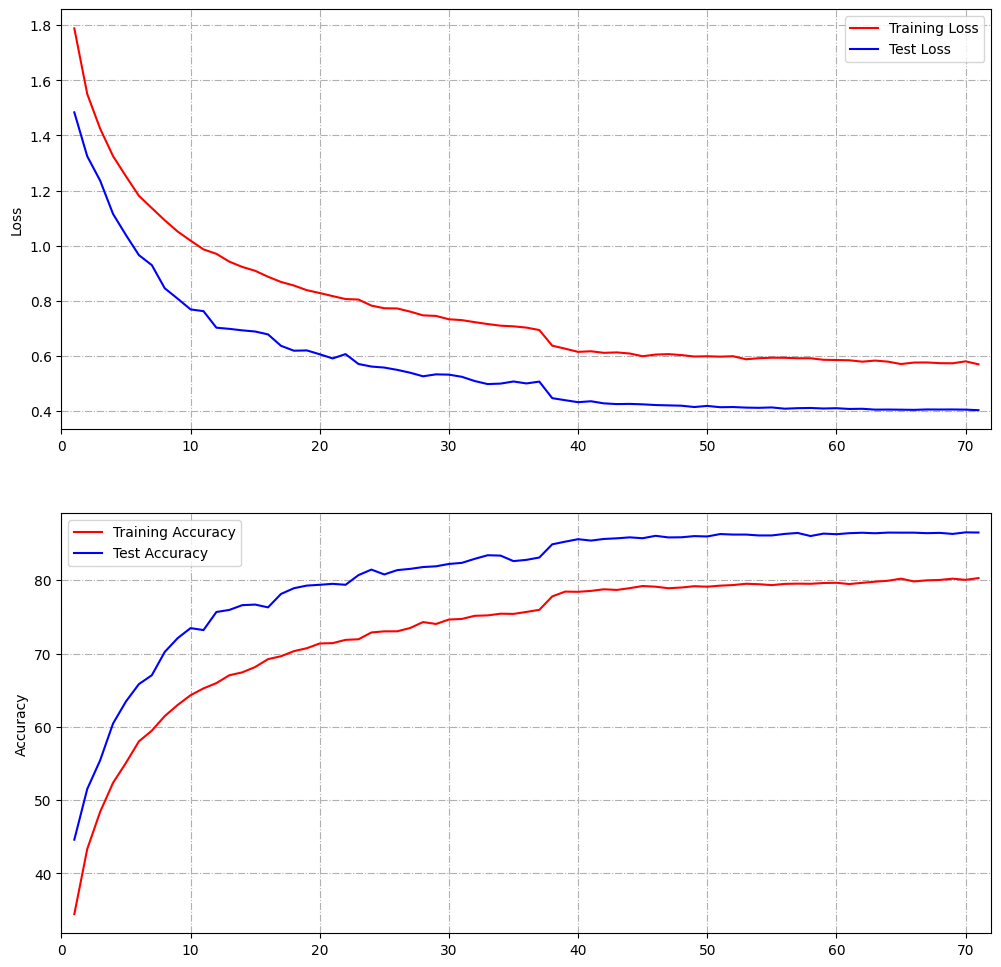

In [59]:
## use function from utils.py
plot_accuracy_losses(train_losses, train_acc, test_losses, test_acc, best_epoch)

## Error analysis

total wrong predictions: 1349


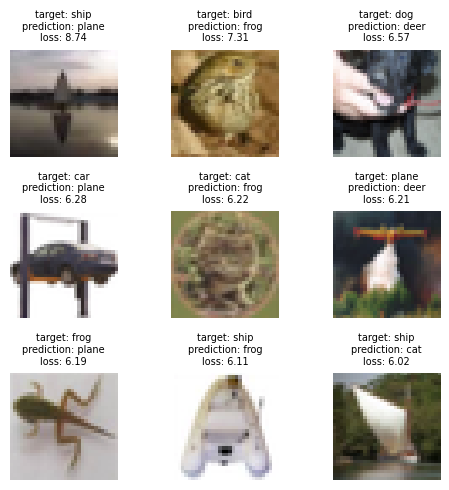

In [60]:
incr_groups_df = plot_top_loss(model, device, test_loader, criterion,
                               label_names = class_labels, img_rows=3, img_cols = 3)

In [61]:
incr_groups_df.loc[incr_groups_df.image > 1]

,target,prediction,loss,image
34,dog,cat,1.496642,118
18,cat,dog,1.364544,83
2,bird,deer,1.963552,57
74,truck,car,1.830366,53
15,cat,bird,1.823239,47
...,...,...,...,...
45,frog,horse,4.512693,2
69,ship,frog,5.069053,2
78,truck,frog,2.740297,2
53,horse,frog,3.538799,2
